
## Test Experiment to Test Instruments

In [1]:
import numpy as np

from rohde_schwarz import SGS100A
from qblox_copy import Pulsar_QCM
from qblox_copy import Pulsar_QRM

from quantify_core.data.handling import get_datadir, set_datadir
from quantify_core.measurement import MeasurementControl
from quantify_core.measurement.control import Settable, Gettable
import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

In [2]:
QRM_settings = {
		'ref_clock': 'external',
        'gain': 0.5,
        'hardware_avg_en': True,
        'hardware_avg': 1024,
        'sequencer': 0,
        'acq_trigger_mode': 'sequencer',
        'sync_en': True,

        'data_dictionary': 'quantify-data/',
        
        'ro_pulse': {	"freq_if": 20e6,
						"amplitude": 0.5, 
						"length": 6000,
						"offset_i": 0,
						"offset_q": 0,
						"shape": "Block",
						"delay_before": 341,
						"repetition_duration": 200000,
                                      },

        'start_sample': 130,
        'integration_length': 600,
        'sampling_rate': 1e9,
        'mode': 'ssb',
}
QCM_settings = {
	'ref_clock': 'external',
        'gain': 0.5,
        'hardware_avg': 1024,
        'sequencer': 0,
        'sync_en': True,
        'pulse': {	"freq_if": 100e6,
					"amplitude": 0.25, 
					"length": 300,
					"offset_i": 0,
					"offset_q": 0,
					"shape": "Gaussian",
					"delay_before": 1, # cannot be 0
					"repetition_duration": 200000,
                                      },
}
QRM_LO_settings = { "power": 10,
					"frequency":7.79813e9 - QRM_settings['ro_pulse']['freq_if'],
}
QCM_LO_settings = { "power": 12,
					"frequency":8.72e9 + QCM_settings['pulse']['freq_if'],
}

In [3]:
LO_qrm = SGS100A("LO_qrm", '192.168.0.7')

Exception: error creating link: 9

In [4]:
LO_qcm = SGS100A("LO_qcm", '192.168.0.101')

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/113300, firmware:4.2.76.0-4.30.046.295) in 0.04s



            move    1024,R0
            nop
            wait_sync 4          # Synchronize sequencers over multiple instruments

        loop:
            wait      344       # idle for xx ns gaussian pulse + 40 ns buffer
            play      0,1,4      # Play waveforms (0,1) in channels (O0,O1) and wait 4ns.
            acquire   0,0,4      # Acquire waveforms over remaining duration of acquisition of input vector of length = 16380 with integration weights 0,0
            wait      16032
            move      183,R1     # repetion rate loop iterator
            nop
            repeatloop:
                wait      1000
                loop      R1,@repeatloop
            wait      620
            loop    R0,@loop

            stop
        


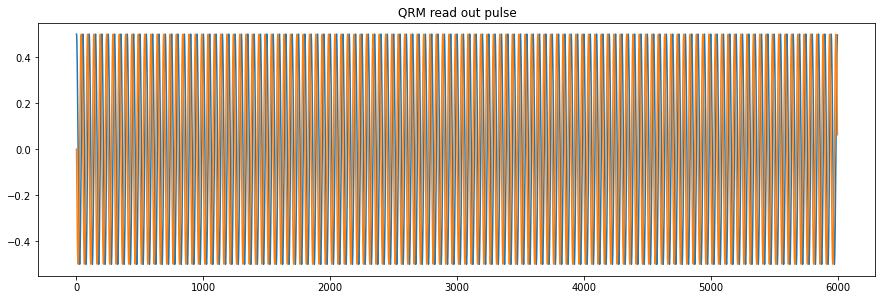

In [5]:
qrm = Pulsar_QRM("qrm", '192.168.0.2')



            move    1024,R0
            nop
            wait_sync 4          # Synchronize sequencers over multiple instruments

        loop:
            wait      4       # idle for xx ns gaussian pulse + 40 ns buffer
            play      0,1,4      # Play waveforms (0,1) in channels (O0,O1) and wait 4ns.
            acquire   0,0,4      # Acquire waveforms over remaining duration of acquisition of input vector of length = 16380 with integration weights 0,0
            wait      16372
            move      183,R1     # repetion rate loop iterator
            nop
            repeatloop:
                wait      1000
                loop      R1,@repeatloop
            wait      620
            loop    R0,@loop

            stop
        


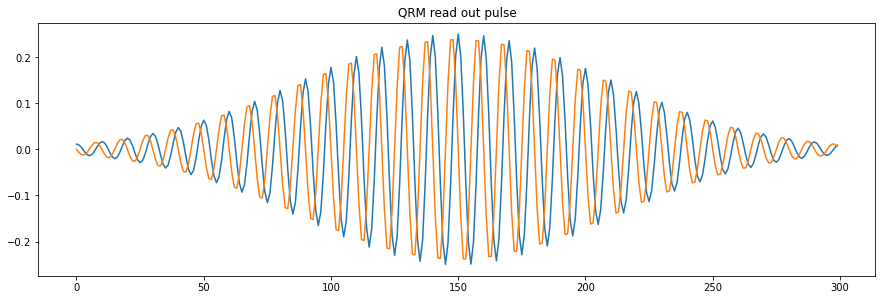

In [6]:
qcm = Pulsar_QCM("qcm", '192.168.0.3')

In [7]:
LO_qrm.set_power(QRM_LO_settings['power'])
LO_qrm.set_frequency(QRM_LO_settings['frequency'])
LO_qcm.set_power(QCM_LO_settings['power'])
LO_qcm.set_frequency(QCM_LO_settings['frequency'])

#qrm.setup(QRM_settings)
#qcm.setup(QCM_settings)

In [8]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon')
insmon = InstrumentMonitor("Instruments Monitor")

MC.instr_plotmon(plotmon.name)
MC.instrument_monitor(insmon.name)

In [9]:
set_datadir(QRM_settings['data_dictionary'])
print(f"Data will be saved in:\n{get_datadir()}")

Data will be saved in:
quantify-data/


In [10]:
LO_qcm.on()
LO_qrm.on()

### Run qubit frequency spectroscopy

In [11]:
soft_avg_numnber = 3

MC.settables(LO_qrm.LO.frequency)
MC.setpoints(np.arange(-20e6,+20e6,0.5e6) + QRM_LO_settings['frequency'])
MC.gettables(Gettable(qrm))

In [ ]:
dataset = MC.run('QubitSpec', soft_avg = soft_avg_numnber)

In [13]:
qrm.stop()
qcm.stop()
LO_qcm.off()
LO_qrm.off()
LO_qrm.close()
LO_qcm.close()
